### Sentiment Analysis of Trading 212 application based on customers review from Trustpilot

## Name: Itunuoluwa Abidoye 202136265

## Course Name: Applied Artificial Intelligence

## Course Code: 771767_A23_T2 

### Web Scraping code ###
### I used this to get my Review Data from Trust Pillot

!pip install mechanize
!pip install beautifulsoup4

from bs4 import BeautifulSoup
import mechanize

br = mechanize.Browser()
br.set_handle_robots(False) #Google demands a user-agent that isn't a robot
br.addheaders = [("User-agent", "GoogleChrome")] #MicrosoftEdge

# Open the webpage to make HTML accessible:
response = br.open("https://uk.trustpilot.com/review/trading212.com")

soup = BeautifulSoup(response.read())
soup

import numpy as np

#n = np.linspace(939, 1132,1132)
### Review pages 1 - 1133
n = list(range(1, 1133))
n = [int(i) for i in n]
n

import pandas as pd

data = []

for i in n:
    link = f"https://uk.trustpilot.com/review/trading212.com?page={i}"
    #data.append(link)
    response = br.open(link)
    web_page = response.read()
    soup = BeautifulSoup(web_page, "html.parser")
    for e in soup.select('article'):
        data.append({
        'review_title':e.h2.text,
        'review_date_original': e.select_one('[data-service-review-date-of-experience-typography]').text.split(': ')[-1],
        'review_rating':e.select_one('[data-service-review-rating] img').get('alt'),
        'review_text': e.select_one('[data-service-review-text-typography]').text 
            if e.select_one('[data-service-review-text-typography]') else None,
        'page_number':i
        })

df = pd.DataFrame([i for i in data])

df['page_number'].unique()

data[0]

df.to_csv('my_tradingdata.csv', index=False)  # Set index=False if you do not want to save the index.

df

### NLP Sentiment Analysis Application Beginning

In [ ]:
### Installing need packages

In [1]:
!pip install gensim
!pip install spacy
!pip install wordcloud
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Importing my Libaries needed for the execution of the solution
import csv
import json
import os
import sys
import re
import gensim
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# My error handling and my dataset loading opening

csv_path = "./my_tradingdata.csv"

try:
    df = pd.read_csv(csv_path) # using Pandas to read in my file 
    # dataframe
except FileNotFoundError as not_found: # File not found error 
    print(f"The file at path '{csv_path}' could not be found.")
except IOError as opening_error:
    print(f"An error occurred while trying to open the file: {opening_error}")
except Exception as exception:
    print(f"An unexpected error occurred: {exception}")

In [4]:
# load my dataset into the file
df
#Regularize put in date time 11:4:2021

,review_title,review_date_original,review_rating,review_text,page_number
0,I love trading 212,03 May 2024,Rated 5 out of 5 stars,"I love trading 212, It's so amazing how fast ...",1
1,Finally I don’t have to choose between…,02 May 2024,Rated 5 out of 5 stars,Finally I don’t have to choose between and sto...,1
2,The app is very easy to use,04 May 2024,Rated 5 out of 5 stars,"The app is very easy to use, and they're alway...",1
3,Good enough app,01 April 2024,Rated 4 out of 5 stars,Good enough app. But still a lot to work to br...,1
4,This is the best company I have been…,10 July 2023,Rated 5 out of 5 stars,This is the best company I have been dealing w...,1
...,...,...,...,...,...
22635,This Company is a scam and there system…,17 November 2018,Rated 1 out of 5 stars,This Company is a scam and there system will g...,1132
22636,Love it,06 September 2018,Rated 5 out of 5 stars,I have been trading with them for over a year....,1132
22637,Thieves,05 September 2018,Rated 1 out of 5 stars,Thieves. Stay clear!!!,1132
22638,Great tools,19 June 2018,Rated 5 out of 5 stars,"Great tools, instruments! I would like to see ...",1132


In [5]:
# Observing the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22640 entries, 0 to 22639
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_title          22640 non-null  object
 1   review_date_original  22640 non-null  object
 2   review_rating         22640 non-null  object
 3   review_text           16841 non-null  object
 4   page_number           22640 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 884.5+ KB


### Data Cleaning

In [6]:
#Checking rows with empty entries
df[df['review_title'] == " "]

,review_title,review_date_original,review_rating,review_text,page_number


In [7]:
#Checking rows with empty entries
df[df['review_title'] == ""]

,review_title,review_date_original,review_rating,review_text,page_number


In [8]:
df[df['review_title'].isna()]

,review_title,review_date_original,review_rating,review_text,page_number


In [9]:
#Checking rows with empty entries
df[df['review_text'] == " "]

,review_title,review_date_original,review_rating,review_text,page_number


In [10]:
#Checking rows with empty entries
df[df['review_text'] == ""]

,review_title,review_date_original,review_rating,review_text,page_number


In [11]:
df['review_text'].isnull().sum()

5799

In [12]:
#Checking rows with empty entries
df[df['review_text'].isnull()]

,review_title,review_date_original,review_rating,review_text,page_number
109,Good platform to utilise ur s&s isa,30 April 2024,Rated 5 out of 5 stars,NaN,6
111,Good app with native language,29 April 2024,Rated 5 out of 5 stars,NaN,6
116,Easy way to get into trading!,29 April 2024,Rated 5 out of 5 stars,NaN,6
130,Great trading app,29 April 2024,Rated 5 out of 5 stars,NaN,7
132,As everything there areas to improve,02 May 2024,Rated 4 out of 5 stars,NaN,7
...,...,...,...,...,...
22587,Great support as usual,30 May 2019,Rated 5 out of 5 stars,NaN,1130
22588,9very helpful customer service care,30 May 2019,Rated 5 out of 5 stars,NaN,1130
22589,Very helpful with any queries.,30 May 2019,Rated 5 out of 5 stars,NaN,1130
22599,Answered my question very fast!,27 May 2019,Rated 5 out of 5 stars,NaN,1130


In [13]:
### Cleaning Review Rating column
df["review_rating"] = df["review_rating"].astype(str).apply(lambda x : re.sub('Rated', '', x))
df["review_rating"] = df["review_rating"].astype(str).apply(lambda x : re.sub('out of 5 stars', '', x))

In [14]:
#Checking rows with empty entries
df[df['review_text'].isnull()]

,review_title,review_date_original,review_rating,review_text,page_number
109,Good platform to utilise ur s&s isa,30 April 2024,5,NaN,6
111,Good app with native language,29 April 2024,5,NaN,6
116,Easy way to get into trading!,29 April 2024,5,NaN,6
130,Great trading app,29 April 2024,5,NaN,7
132,As everything there areas to improve,02 May 2024,4,NaN,7
...,...,...,...,...,...
22587,Great support as usual,30 May 2019,5,NaN,1130
22588,9very helpful customer service care,30 May 2019,5,NaN,1130
22589,Very helpful with any queries.,30 May 2019,5,NaN,1130
22599,Answered my question very fast!,27 May 2019,5,NaN,1130


In [15]:
# Convert column to integer
df['review_rating'] = df['review_rating'].astype(int)

In [16]:
# Convert review_rating to integer
df['review_rating'] = df['review_rating'].astype('int64')

In [17]:
# Replace NaN values in 'review_text' with empty strings to handle them uniformly
df['review_text'].fillna('', inplace=True)

#  Impute Based on the rating to correct the empty review text column
# Assuming a rating >= 3 is positive and <= 2 is negative
df.loc[(df['review_text'] == '') & (df['review_rating'] >= 3), 'review_text'] = 'Positive review'
df.loc[(df['review_text'] == '') & (df['review_rating'] <= 2), 'review_text'] = 'Negative review'


In [18]:
# Confirming Checking rows with empty entries
df[df['review_text'].isnull()]

,review_title,review_date_original,review_rating,review_text,page_number


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22640 entries, 0 to 22639
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_title          22640 non-null  object
 1   review_date_original  22640 non-null  object
 2   review_rating         22640 non-null  int64 
 3   review_text           22640 non-null  object
 4   page_number           22640 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 884.5+ KB


# Data Text Cleaning

In [20]:
# Data text cleaning to remove punctuations and convert text to lower

def clean_text(column_names):
    # remove punctuations
    df[column_names] = df[column_names].astype(str).apply(lambda x : re.sub('[,\.?!@#]', '', x))
    
    # Convert to lowercase
    df[column_names] = df[column_names].astype(str).apply(lambda x: x.lower())


In [21]:
# Clean text for review text
column_text = "review_text"
clean_text(column_text)

In [22]:
# Clean text for review title
column_title = "review_title"
clean_text(column_title)

In [23]:
df

,review_title,review_date_original,review_rating,review_text,page_number
0,i love trading 212,03 May 2024,5,i love trading 212 it's so amazing how fast t...,1
1,finally i don’t have to choose between…,02 May 2024,5,finally i don’t have to choose between and sto...,1
2,the app is very easy to use,04 May 2024,5,the app is very easy to use and they're always...,1
3,good enough app,01 April 2024,4,good enough app but still a lot to work to bri...,1
4,this is the best company i have been…,10 July 2023,5,this is the best company i have been dealing w...,1
...,...,...,...,...,...
22635,this company is a scam and there system…,17 November 2018,1,this company is a scam and there system will g...,1132
22636,love it,06 September 2018,5,i have been trading with them for over a year ...,1132
22637,thieves,05 September 2018,1,thieves stay clear,1132
22638,great tools,19 June 2018,5,great tools instruments i would like to see mo...,1132


### Sentiment Category

In [24]:
# Create a Sentiment Column Positive/Negative I am considering from 3 and above as Positive while 2 and below as Negative
df['sentiment'] = df['review_rating'].apply(lambda x: 'positive' if x >= 3 else 'negative')

In [25]:
df

,review_title,review_date_original,review_rating,review_text,page_number,sentiment
0,i love trading 212,03 May 2024,5,i love trading 212 it's so amazing how fast t...,1,positive
1,finally i don’t have to choose between…,02 May 2024,5,finally i don’t have to choose between and sto...,1,positive
2,the app is very easy to use,04 May 2024,5,the app is very easy to use and they're always...,1,positive
3,good enough app,01 April 2024,4,good enough app but still a lot to work to bri...,1,positive
4,this is the best company i have been…,10 July 2023,5,this is the best company i have been dealing w...,1,positive
...,...,...,...,...,...,...
22635,this company is a scam and there system…,17 November 2018,1,this company is a scam and there system will g...,1132,negative
22636,love it,06 September 2018,5,i have been trading with them for over a year ...,1132,positive
22637,thieves,05 September 2018,1,thieves stay clear,1132,negative
22638,great tools,19 June 2018,5,great tools instruments i would like to see mo...,1132,positive


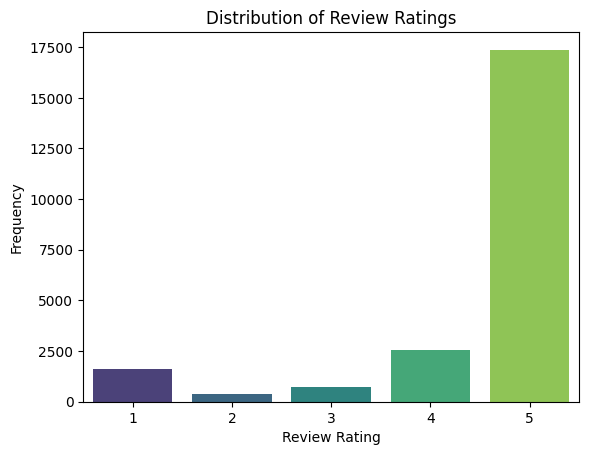

In [26]:
# Assuming 'review_rating' is already converted to integer if necessary
sns.countplot(x=df['review_rating'], palette='viridis')  # You can choose other palettes like 'muted', 'bright', etc.
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

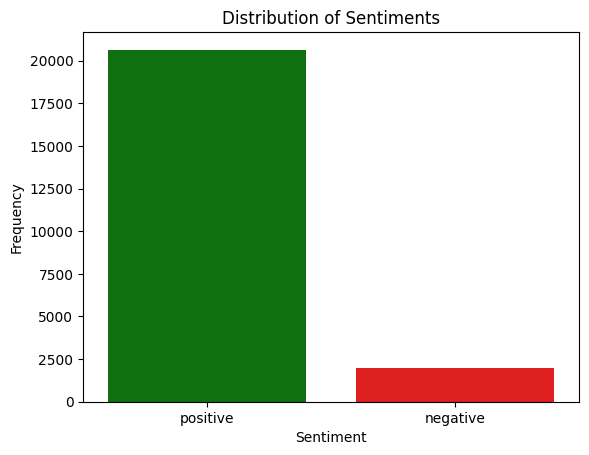

In [27]:
# Define a color palette
palette = {'positive': 'green', 'negative': 'red'}

# Create the plot
sns.countplot(x='sentiment', data=df, palette=palette)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [ ]:
### Word Tokenization

In [28]:
def sent_to_words(sentences):
    # Sentence to words function
    for sentence in sentences:
        yield(simple_preprocess(sentence, deacc=False))

In [29]:
data = df['review_text'].to_list()

In [30]:
data_words = list(sent_to_words(data))

In [31]:
### Generate the bigrams and trigrams

In [32]:
bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=100) #bigrams

trigram = gensim.models.phrases.Phrases(bigram[data_words], threshold=100) #trigrams

In [33]:
bigram[data_words]

In [34]:
#Bigam and Trigram models
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
### Bigrams

In [35]:
for bigram in bigram_mod.phrasegrams.keys():
    print(bigram)

uninvested_cash
hargreaves_lansdown
these_guys
user_friendly
turn_off
social_media
debit_card
most_important
game_changer
highly_recommend
timely_manner
tax_purposes
within_minutes
share_lending
pie_feature
straight_forward
long_term
interest_rates
hard_earned
link_wwwtrading
dot_com
com_invite
less_than
hidden_charges
trust_pilot
right_direction
apple_pay
multi_currency
driving_licence
interactive_brokers
national_insurance
sign_up
referral_link
rather_than
small_amounts
wide_range
five_stars
non_existent
who_wants
highly_recommended
laid_out
yahoo_finance
payment_methods
dividend_payments
zero_commission
signing_up
practice_mode
within_seconds
star_rating
exchange_rate
payment_method
stay_away
reference_number
financial_conduct
conduct_authority
right_away
financial_ombudsman
stop_loss
screen_shots
shut_down
trailing_stop
technical_analysis
anywhere_else
signed_up
trust_worthy
difference_between
straight_away
top_notch
community_forum
retail_investors
first_class
credit_card
dividend

In [ ]:
### Trigrams

In [36]:
for trigram in trigram_mod.phrasegrams.keys():
    print(trigram)

uninvested_cash
these_guys
user_friendly
turn_off
social_media
debit_card
most_important
highly_recommend
interest_rate
timely_manner
tax_purposes
within_minutes
fx_rates
share_lending
pie_feature
user_interface
straight_forward
long_term
interest_rates
hard_earned
link_wwwtrading
dot_com
less_than
hidden_charges
trust_pilot
right_direction
apple_pay
driving_licence
interactive_brokers
national_insurance
sign_up
referral_link
rather_than
small_amounts
wide_range
exchange_rates
five_stars
non_existent
who_wants
highly_recommended
yahoo_finance
payment_methods
dividend_payments
zero_commission
signing_up
practice_mode
within_seconds
star_rating
exchange_rate
payment_method
wide_variety
stay_away
reference_number
telephone_number
financial_conduct
financial_conduct_authority
right_away
financial_ombudsman
referral_code
stop_loss
shut_down
trailing_stop
technical_analysis
anywhere_else
looking_forward
signed_up
trust_worthy
difference_between
straight_away
top_notch
community_forum
retail_

## Lemmatisation and Stopwords

In this section we lemmatise (convert words to their base forms) and remove "stopwords" - words that we want to filter out because they are not useful.

In [37]:
from gensim.parsing.preprocessing import STOPWORDS

In [38]:
# Adding stopwords to the list here
my_stop_words = STOPWORDS.union(set(['br']))

In [39]:
# Stop words functions
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]

In [40]:
data_words_no_stops = remove_stopwords(data_words)

In [41]:
# Bigrams and Trigrams

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [42]:
data_words_bigrams = make_bigrams(data_words_no_stops)
data_words_trigrams = make_trigrams(data_words_no_stops)

In [43]:
# Trigram words
for i, text in enumerate(data_words_trigrams):
    for word in text:
        if "_" in word:
            print(i, word)

1 uninvested_cash
1 hargreaves_lansdown
3 user_friendly
5 uninvested_cash
5 social_media
9 user_friendly
12 user_friendly
14 debit_card
16 uninvested_cash
21 uninvested_cash
24 uninvested_cash
27 user_friendly
30 uninvested_cash
46 debit_card
48 game_changer
53 user_friendly
56 highly_recommend
64 timely_manner
77 tax_purposes
106 user_friendly
126 uninvested_cash
158 highly_recommend
177 user_friendly
195 user_friendly
200 user_friendly
200 fx_rates
205 uninvested_cash
207 share_lending
230 user_friendly
232 pie_feature
234 user_friendly
237 pie_feature
239 uninvested_cash
240 user_interface
246 straight_forward
247 long_term
259 pie_feature
267 hard_earned
267 debit_card
276 link_wwwtrading
276 dot_com
278 straight_forward
284 user_friendly
291 user_friendly
291 hidden_charges
307 debit_card
307 trust_pilot
317 uninvested_cash
319 right_direction
336 apple_pay
337 user_friendly
346 multi_currency
346 debit_card
356 pie_feature
362 uninvested_cash
363 debit_card
380 driving_licence
38

In [ ]:
### Lemmatization function

In [44]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in
                            allowed_postags])
    return texts_out

In [45]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.4/12.8 MB 8.3 MB/s eta 0:00:02
     --- ------------------------------------ 1.0/12.8 MB 10.2 MB/s eta 0:00:02
     ---- ----------------------------------- 1.6/12.8 MB 11.3 MB/s eta 0:00:01
     ------- -------------------------------- 2.4/12.8 MB 12.5 MB/s eta 0:00:01
     ---------- ----------------------------- 3.4/12.8 MB 14.5 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 17.7 MB/s eta 0:00:01
     --------------------- ------------------ 7.0/12.8 MB 21.2 MB/s eta 0:00:01
     -------------------------- ------------- 8.6/12.8 MB 22.8 MB/s eta 0:00:01
     ---------------------------------- ---- 11.4/12.8 MB 32.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 36.3 MB/s eta 0:00:00
[+] Download and installation successful
You can no


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams)

print('data_lemmatized[:1]', data_lemmatized[:1])

data_lemmatized[:1] [['love', 'trading', 'amazing', 'fast', 'withdraw', 'arrive', 'withdraw', 'twice', 'times', 'money', 'arrive', 'day', 'long', 'request', 'appreciate', 'make', 'happy', 'day', 'request', 'early', 'afternoon', 'think', 'allow', 'working', 'day', 'day', 'thankfuli', 'recommend']]


## Generating a WordCloud

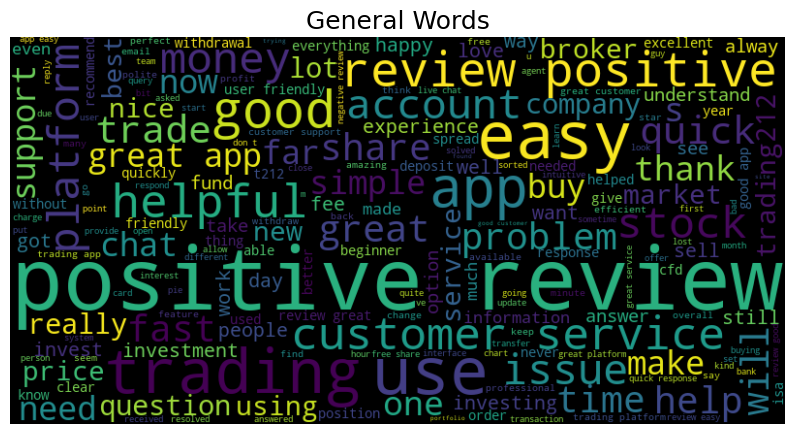

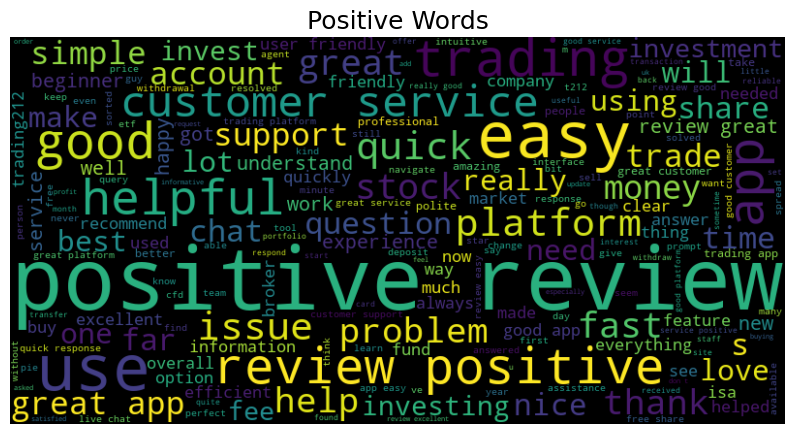

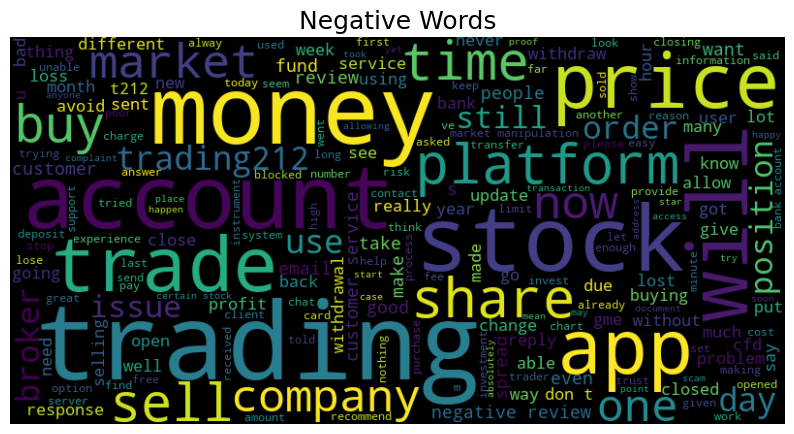

In [47]:
def generate_word_cloud(text, title):
    # Word cloud function
    wordcloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110, background_color='black').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

# Concatenate all review texts for a general word cloud
all_text = " ".join(review for review in df.review_text)

# Concatenate review texts based on sentiment for specific word clouds
positive_text = " ".join(review for review in df[df['sentiment'] == 'positive'].review_text)
negative_text = " ".join(review for review in df[df['sentiment'] == 'negative'].review_text)

# Generate Word Clouds
generate_word_cloud(all_text, 'General Words')
generate_word_cloud(positive_text, 'Positive Words')
generate_word_cloud(negative_text, 'Negative Words',)


In [ ]:
### Wordcloud alternative

In [48]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  
from nltk.stem import WordNetLemmatizer
import nltk

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\690303\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
# getting the text based on ratings 
rating_post = df['review_text'][df['sentiment'] == 'positive'] 
rating_neg = df['review_text'][df['sentiment'] == 'negative']


# word tokenize the data 
def list_tokenizer(rating): 
    ratings = " ".join(rating)
    ratings = nltk.word_tokenize(ratings)
    return str(ratings)

# visualizer 
def word_cloud(rating, number): 
    wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)  
    wc.generate(rating)  
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation = 'bilinear')  
    plt.title(f'WordCloud for {number}')
    plt.axis('off');

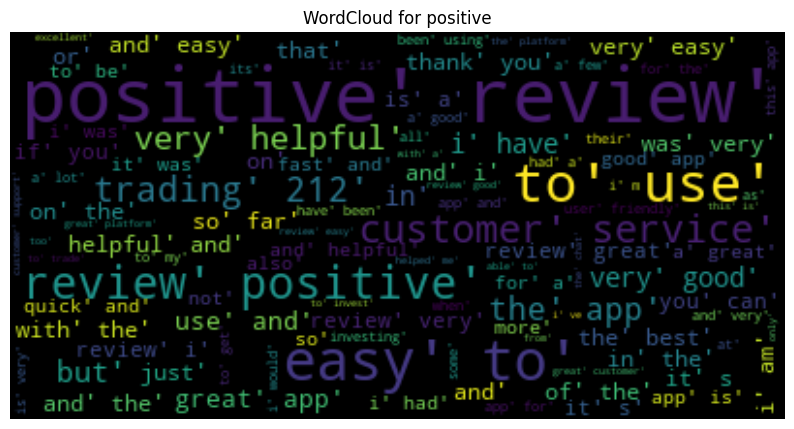

In [52]:
# Let's visuailze the ratings
word_cloud(list_tokenizer(rating_post), 'positive')

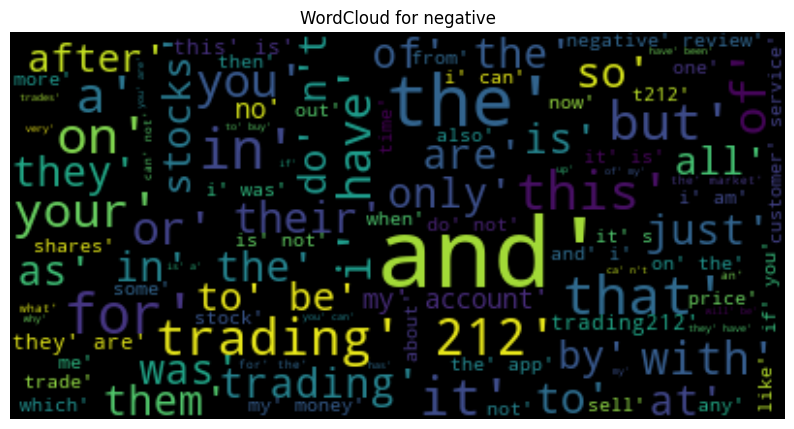

In [53]:
word_cloud(list_tokenizer(rating_neg), 'negative')

### Data Balancing

In [54]:
# split df - positive and negative sentiment:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

In [55]:
df

,review_title,review_date_original,review_rating,review_text,page_number,sentiment
0,i love trading 212,03 May 2024,5,i love trading 212 it's so amazing how fast t...,1,positive
1,finally i don’t have to choose between…,02 May 2024,5,finally i don’t have to choose between and sto...,1,positive
2,the app is very easy to use,04 May 2024,5,the app is very easy to use and they're always...,1,positive
3,good enough app,01 April 2024,4,good enough app but still a lot to work to bri...,1,positive
4,this is the best company i have been…,10 July 2023,5,this is the best company i have been dealing w...,1,positive
...,...,...,...,...,...,...
22635,this company is a scam and there system…,17 November 2018,1,this company is a scam and there system will g...,1132,negative
22636,love it,06 September 2018,5,i have been trading with them for over a year ...,1132,positive
22637,thieves,05 September 2018,1,thieves stay clear,1132,negative
22638,great tools,19 June 2018,5,great tools instruments i would like to see mo...,1132,positive


In [56]:
### Data Resampling

import pandas as pd
from sklearn.utils import resample


# Display the initial class distribution
print("Initial class distribution:\n", df['review_rating'].value_counts())

# Undersample the dataset : Minority data
df_undersampled = pd.DataFrame()
min_size = df['review_rating'].value_counts().min()  # size of the minority class

for rating in df['review_rating'].unique():
    df_class = df[df['review_rating'] == rating]
    df_class_undersampled = resample(df_class, 
                                     replace=False,    # sample without replacement
                                     n_samples=min_size,  # to match minority class
                                     random_state=123)  # reproducible results
    df_undersampled = pd.concat([df_undersampled, df_class_undersampled], axis=0)

# Oversample the dataset: Majority class
df_oversampled = pd.DataFrame()
max_size = df['review_rating'].value_counts().max()  # size of the Majority class

for rating in df['review_rating'].unique():
    df_class = df[df['review_rating'] == rating]
    df_class_oversampled = resample(df_class, 
                                    replace=True,     # sample with replacement
                                    n_samples=max_size,  # to match majority class
                                    random_state=123)  # reproducible results
    df_oversampled = pd.concat([df_oversampled, df_class_oversampled], axis=0)

# Display the new class distributions data
print("Undersampled class distribution:\n", df_undersampled['review_rating'].value_counts())
print("Oversampled class distribution:\n", df_oversampled['review_rating'].value_counts())


Initial class distribution:
 review_rating
5    17375
4     2540
1     1619
3      728
2      378
Name: count, dtype: int64
Undersampled class distribution:
 review_rating
5    378
4    378
1    378
3    378
2    378
Name: count, dtype: int64
Oversampled class distribution:
 review_rating
5    17375
4    17375
1    17375
3    17375
2    17375
Name: count, dtype: int64


In [57]:
# Oversample the dataset
df_oversampled = pd.DataFrame()
max_size = df['sentiment'].value_counts().max()  # size of the largest class

for rating in df['sentiment'].unique():
    df_class = df[df['sentiment'] == rating]
    df_class_oversampled = resample(df_class, 
                                    replace=True,     # sample with replacement
                                    n_samples=max_size,  # to match majority class
                                    random_state=123)  # reproducible results
    df_oversampled = pd.concat([df_oversampled, df_class_oversampled], axis=0)

# Display the new class distributions
print("Undersampled class distribution:\n", df_undersampled['sentiment'].value_counts())
print("Oversampled class distribution:\n", df_oversampled['sentiment'].value_counts())


Undersampled class distribution:
 sentiment
positive    1134
negative     756
Name: count, dtype: int64
Oversampled class distribution:
 sentiment
positive    20643
negative    20643
Name: count, dtype: int64


### Plot Distributions

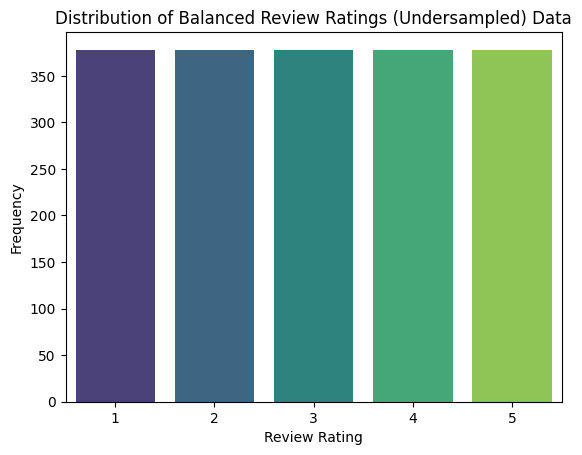

In [58]:
#Plot Distribution graph of balanced Minority data using undersampled minority
sns.countplot(x=df_undersampled['review_rating'], palette='viridis') 
plt.title('Distribution of Balanced Review Ratings (Undersampled) Data')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

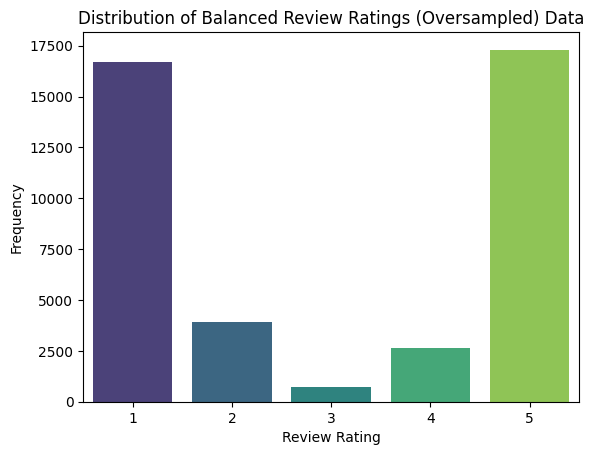

In [59]:
#Plot Distribution graph of balanced Majority data using oversampled data
sns.countplot(x=df_oversampled['review_rating'], palette='viridis')
plt.title('Distribution of Balanced Review Ratings (Oversampled) Data')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.show()

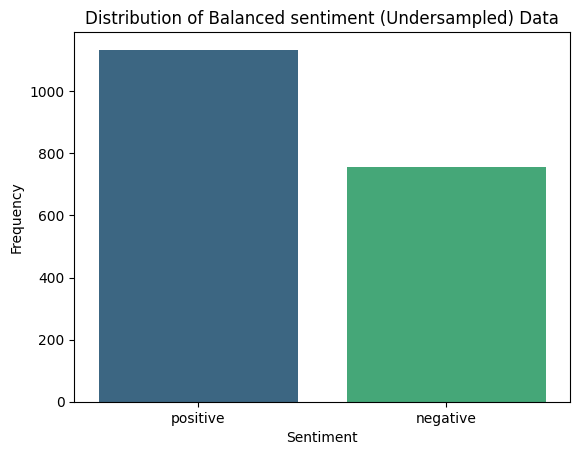

In [60]:
#Plot Distribution graph of balanced data Sentiment Undersampled data
sns.countplot(x=df_undersampled['sentiment'], palette='viridis') 
plt.title('Distribution of Balanced sentiment (Undersampled) Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

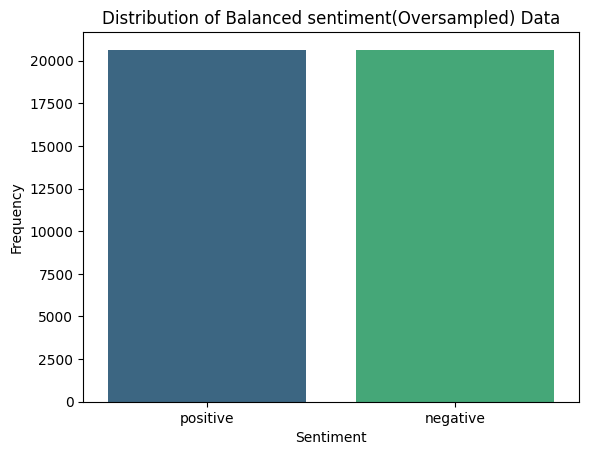

In [61]:
#Plot Distribution graph of balanced data Sentiment Oversampled Data
sns.countplot(x=df_oversampled['sentiment'], palette='viridis')
plt.title('Distribution of Balanced sentiment(Oversampled) Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

### The Under sampled Data is more Blanced so I will be going ahead to use the more blanced data

### Processing

1. Data loading and preprocessing.
2. Feature engineering using TF-IDF.
3. Implementing a Naive Bayes classifier.
4. Implementing a Multinomial logistic Regression and SVM
5. Setting up a simple GRU, RNN and LSTM for sentiment analysis.

## Training a Sentiment Classifier

Ready to classify the sentiments of the reviews. 
The data is the oversampled text review, the label is whether it is positive or negative.

In [ ]:
### import tensorflow package

In [62]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.4.2 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.10.1 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
typeguard 4.1.5 requires typing-extensions>=4.7.0; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
# Training with Review Text and Sentiments

In [65]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    #df['review_text'], df['sentiment'], test_size=0.2, random_state=42
    #df_oversampled['sentiment'], df_oversampled['review_rating'], test_size=0.2, random_state=42)
    #df_undersampled['review_text'], df_undersampled['sentiment'], test_size=0.2, random_state=42)
    df_oversampled['review_text'], df_oversampled['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
# Review oversampled text view

In [66]:
 df_oversampled['review_text']

21901                                 great app very handy
17346                                      positive review
19453    this is a great broker for people who are star...
16918    i am a relatively new trader and the level of ...
8202                                       positive review
                               ...                        
12912    restricting options of buying shares for some ...
19804    good sọ far however i will love to see social ...
14626    few months ago i left another platorm for 212 ...
439      they have an offer of a free share if you sign...
14974    hii was trying to sell the stocks with profit ...
Name: review_text, Length: 41286, dtype: object

In [67]:
df

,review_title,review_date_original,review_rating,review_text,page_number,sentiment
0,i love trading 212,03 May 2024,5,i love trading 212 it's so amazing how fast t...,1,positive
1,finally i don’t have to choose between…,02 May 2024,5,finally i don’t have to choose between and sto...,1,positive
2,the app is very easy to use,04 May 2024,5,the app is very easy to use and they're always...,1,positive
3,good enough app,01 April 2024,4,good enough app but still a lot to work to bri...,1,positive
4,this is the best company i have been…,10 July 2023,5,this is the best company i have been dealing w...,1,positive
...,...,...,...,...,...,...
22635,this company is a scam and there system…,17 November 2018,1,this company is a scam and there system will g...,1132,negative
22636,love it,06 September 2018,5,i have been trading with them for over a year ...,1132,positive
22637,thieves,05 September 2018,1,thieves stay clear,1132,negative
22638,great tools,19 June 2018,5,great tools instruments i would like to see mo...,1132,positive


In [68]:
 df_oversampled ## Review oversampled text view

,review_title,review_date_original,review_rating,review_text,page_number,sentiment
21901,great app,22 January 2020,5,great app very handy,1096,positive
17346,excellent chat and very helpful,17 November 2020,5,positive review,868,positive
19453,this is a great broker for people who…,16 July 2020,5,this is a great broker for people who are star...,973,positive
16918,trading with a trading 212,02 December 2020,5,i am a relatively new trader and the level of ...,846,positive
8202,exellent sirvice so far,14 February 2022,5,positive review,411,positive
...,...,...,...,...,...,...
12912,restricting options of buying shares…,06 May 2021,2,restricting options of buying shares for some ...,646,negative
19804,good sọ far however i will love to see…,26 June 2020,1,good sọ far however i will love to see social ...,991,negative
14626,few months ago i left another platorm…,10 March 2021,1,few months ago i left another platorm for 212 ...,732,negative
439,user interface is not functional,16 April 2024,2,they have an offer of a free share if you sign...,22,negative


In [69]:
df_undersampled ## Review undersampled text view

,review_title,review_date_original,review_rating,review_text,page_number,sentiment
4930,thanks trading 212,02 May 2023,5,positive review,247,positive
21807,very good,10 February 2020,5,trading 212 has been faithful to their promise,1091,positive
18127,quick chat,12 October 2020,5,excellent and quick to answer my question,907,positive
912,very good communication throughout,22 March 2024,5,positive review,46,positive
17913,so easy to use and free,22 October 2020,5,positive review,896,positive
...,...,...,...,...,...,...
649,i don’t understand in an electronic…,04 April 2024,2,i don’t understand in an electronic system how...,33,negative
15285,market manipulation 212,28 January 2021,2,have used trading212 for a bit over half a yea...,765,negative
8489,is very dificult to use in mobile app,24 January 2022,2,negative review,425,negative
20219,very disappointed with the trading 212,03 June 2020,2,very disappointed with the trading 212 i do ad...,1011,negative


## Traditional Models

Naive Bayes Multinomial Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.97      0.95      4181
    positive       0.97      0.92      0.94      4077

    accuracy                           0.95      8258
   macro avg       0.95      0.95      0.95      8258
weighted avg       0.95      0.95      0.95      8258



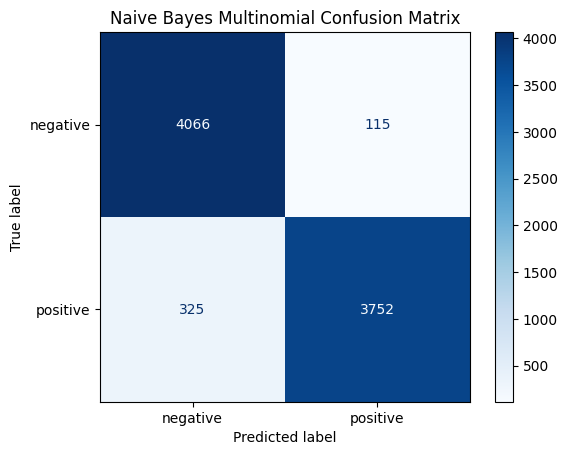

In [70]:
# importing libraries for traditional model
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# confusion matrix function for all the traditional model
def plot_confusion_matrix(y_true, y_pred, labels, title, cmap):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()

# Multinomial Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)

# Calling the Classification Report function
print("Naive Bayes Multinomial Classification Report:")
print(classification_report(y_test, nb_predictions))
plot_confusion_matrix(y_test, nb_predictions, nb_classifier.classes_, 'Naive Bayes Multinomial Confusion Matrix', plt.cm.Blues)


### Regularization Multinomial Naive Bayes Classifier (Alpha)

Best alpha: 0.01 with accuracy score: 0.958222329861952
Classification Report for the Best Alpha:
              precision    recall  f1-score   support

    negative       0.94      0.98      0.96      4181
    positive       0.97      0.94      0.96      4077

    accuracy                           0.96      8258
   macro avg       0.96      0.96      0.96      8258
weighted avg       0.96      0.96      0.96      8258



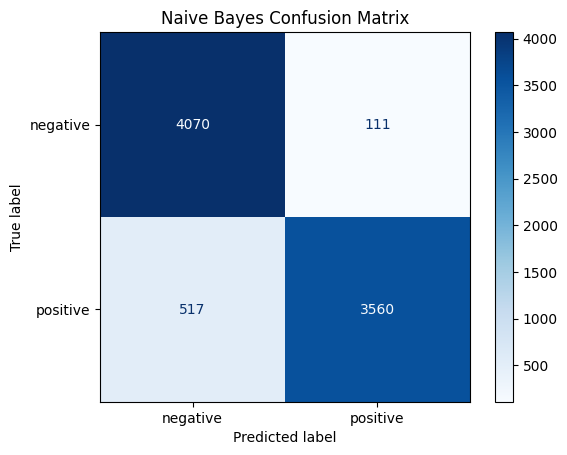

In [71]:
# import libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define alpha values for testing
# Multinomial Naive Bayes Classifier with alpha smoothing regularizer
alphas = [0.01, 0.1, 1.0, 10.0]

best_alpha = None
best_score = 0
best_report = None

for alpha in alphas:
    # Training the model with the current alpha value
    nb_classifier_reg = MultinomialNB(alpha=alpha)
    nb_classifier_reg.fit(X_train_tfidf, y_train)
    
    # Predict the test set
    nb_predictions_reg = nb_classifier_reg.predict(X_test_tfidf)
    
    # Evaluate the model
    score = nb_classifier_reg.score(X_test_tfidf, y_test)
    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_report = classification_report(y_test, nb_predictions_reg)
    
# Print the best alpha value and the classification report
print(f"Best alpha: {best_alpha} with accuracy score: {best_score}")
print("Classification Report for the Best Alpha:")
print(best_report)

#confusion matrix for the best model
plot_confusion_matrix(y_test, nb_predictions_reg, nb_classifier_reg.classes_, 'Naive Bayes Confusion Matrix', plt.cm.Blues)


### HyperParameter for Multinomial NB (GridSearch)

Best alpha: {'alpha': 0.01}
Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.98      0.96      4181
    positive       0.97      0.94      0.96      4077

    accuracy                           0.96      8258
   macro avg       0.96      0.96      0.96      8258
weighted avg       0.96      0.96      0.96      8258



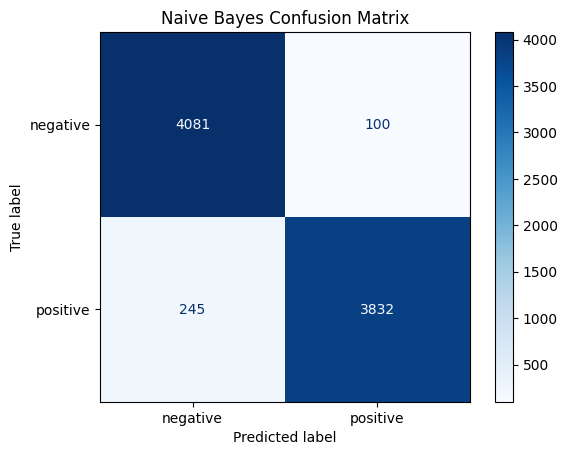

In [72]:
# Grid search to test a range of alpha values
nb_parameters_hp = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
nb_classifier_hp = MultinomialNB()

#Gridsearch classifier
grid_search = GridSearchCV(nb_classifier_hp, nb_parameters_hp, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best grid search estimator
print("Best alpha:", grid_search.best_params_)
best_nb_hp = grid_search.best_estimator_

# Predict with the best estimator
nb_predictions_hp = best_nb_hp.predict(X_test_tfidf)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions_hp))

#confusion matrix for the best model
plot_confusion_matrix(y_test, nb_predictions_hp, best_nb_hp.classes_, 'Naive Bayes Confusion Matrix', plt.cm.Blues)


### Logistic Regression Classifier

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.98      0.97      4181
    positive       0.98      0.95      0.96      4077

    accuracy                           0.97      8258
   macro avg       0.97      0.97      0.97      8258
weighted avg       0.97      0.97      0.97      8258



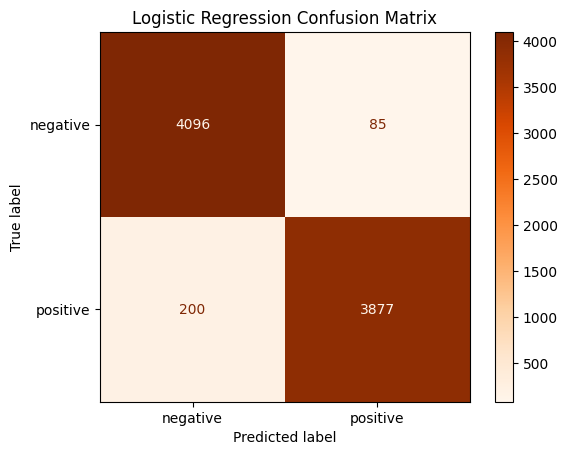

In [73]:
# Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_tfidf, y_train)
log_reg_predictions = log_reg.predict(X_test_tfidf)

# Calling Classification Report function
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))
plot_confusion_matrix(y_test, log_reg_predictions, log_reg.classes_, 'Logistic Regression Confusion Matrix', plt.cm.Oranges)

### Regularization Logistic Regression Classifier

Logistic Regression Classification Report (with initial regularization):
              precision    recall  f1-score   support

    negative       0.95      0.98      0.97      4181
    positive       0.98      0.95      0.97      4077

    accuracy                           0.97      8258
   macro avg       0.97      0.97      0.97      8258
weighted avg       0.97      0.97      0.97      8258



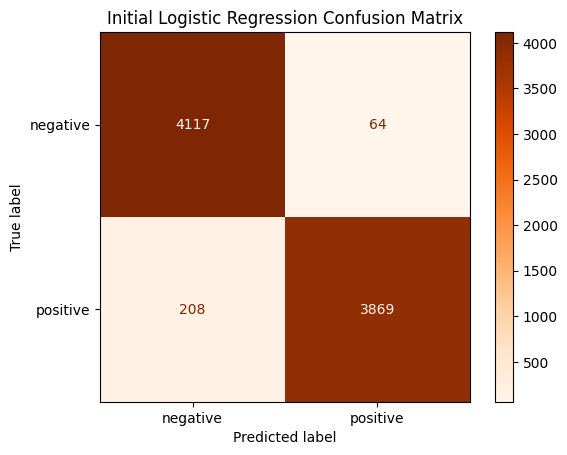

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Using L1 regularization with a specific strength 1
log_reg_rg = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=42)
log_reg_rg.fit(X_train_tfidf, y_train)
log_reg_predictions_rg = log_reg_rg.predict(X_test_tfidf)

# Displaying the classification report for the initial regularization setup
print("Logistic Regression Classification Report (with initial regularization):")
print(classification_report(y_test, log_reg_predictions_rg))

#confusion matrix for the best model
plot_confusion_matrix(y_test, log_reg_predictions_rg, log_reg_rg.classes_, 'Initial Logistic Regression Confusion Matrix', plt.cm.Oranges)


### Hyper Parameter  Logistic Regression Classifier GridSearchCV 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99      4181
    positive       1.00      0.98      0.99      4077

    accuracy                           0.99      8258
   macro avg       0.99      0.99      0.99      8258
weighted avg       0.99      0.99      0.99      8258



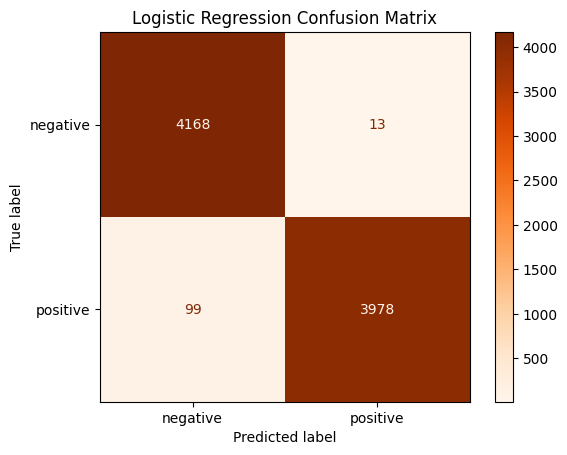

In [75]:
from sklearn.model_selection import GridSearchCV

# Setup grid search parameters
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear']  # Solver that supports L1 regularization
}

# Using Grid search with cross-validation
log_reg_grid = GridSearchCV(LogisticRegression(random_state=42), log_reg_params, cv=5, verbose=1)
log_reg_grid.fit(X_train_tfidf, y_train)

# Evaluate the best model found by grid search
best_log_reg_hp = log_reg_grid.best_estimator_
log_reg_predictions_hp = best_log_reg_hp.predict(X_test_tfidf)

#displaying the classification report
print("Best Logistic Regression Parameters:", log_reg_grid.best_params_)
print(classification_report(y_test, log_reg_predictions_hp))

#confusion matrix for the best model
plot_confusion_matrix(y_test, log_reg_predictions_hp, best_log_reg_hp.classes_, 'Logistic Regression Confusion Matrix', plt.cm.Oranges)


### Support Vector Machines Classifier

Support Vector Machines Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.98      0.98      4181
    positive       0.98      0.97      0.98      4077

    accuracy                           0.98      8258
   macro avg       0.98      0.98      0.98      8258
weighted avg       0.98      0.98      0.98      8258



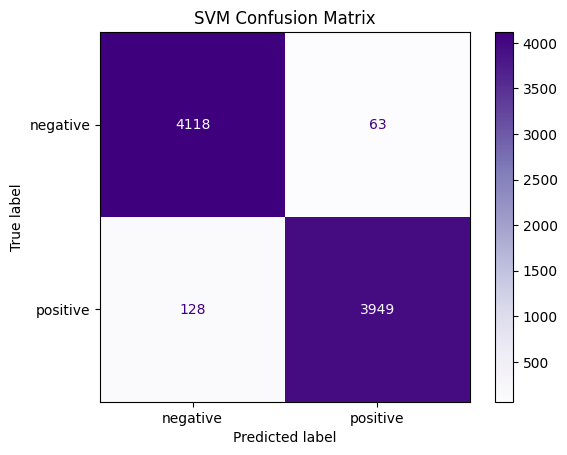

In [76]:
# Support Vector Machines Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)

#calling the Classification Report function
print("Support Vector Machines Classification Report:")
print(classification_report(y_test, svm_predictions))

#confusion matrix for the best model
plot_confusion_matrix(y_test, svm_predictions, svm_classifier.classes_, 'SVM Confusion Matrix', plt.cm.Purples)

### Regularization for SVM using different values of C

SVM Classification Report for Best C=10:
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99      4181
    positive       1.00      0.98      0.99      4077

    accuracy                           0.99      8258
   macro avg       0.99      0.99      0.99      8258
weighted avg       0.99      0.99      0.99      8258



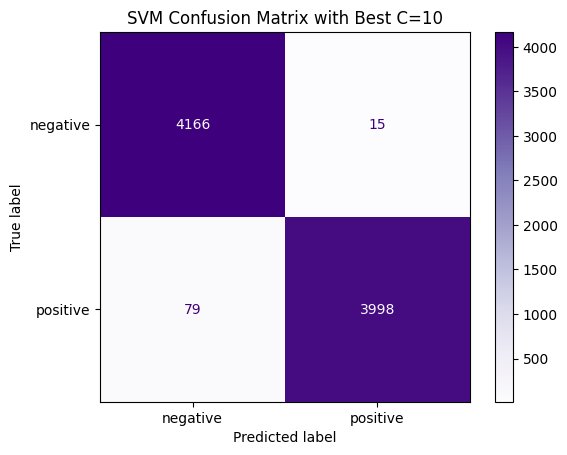

In [77]:
from sklearn.metrics import classification_report, accuracy_score

# Defining C values and initialize variables to track the best model
C_values = [0.1, 1, 10, 100]
best_C_svm = None
best_score_svm = 0
best_report_svm = None
best_predictions_svm = None
best_classes_svm = None

for C in C_values:
    # Train the SVM model with the current C value
    svm_classifier_reg = SVC(kernel='linear', C=C, random_state=42)
    svm_classifier_reg.fit(X_train_tfidf, y_train)
    svm_predictions_reg = svm_classifier_reg.predict(X_test_tfidf)

    # Calculate accuracy
    current_score_svm = accuracy_score(y_test, svm_predictions_reg)

    # Update the best model if the current model is better
    if current_score_svm > best_score_svm:
        best_score_svm = current_score_svm
        best_C_svm = C
        best_report_svm = classification_report(y_test, svm_predictions_reg)
        best_predictions_svm = svm_predictions_reg
        best_classes_svm = svm_classifier_reg.classes_

#output results for the best C value
print(f"SVM Classification Report for Best C={best_C_svm}:")
print(best_report_svm)

#confusion matrix for the best model
plot_confusion_matrix(y_test, best_predictions_svm, best_classes_svm, f'SVM Confusion Matrix with Best C={best_C_svm}', plt.cm.Purples)


### Hyper Parameter SVM Using GridSearchCV 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Optimized SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.99      1.00      1.00      4181
    positive       1.00      0.99      0.99      4077

    accuracy                           1.00      8258
   macro avg       1.00      0.99      1.00      8258
weighted avg       1.00      1.00      1.00      8258



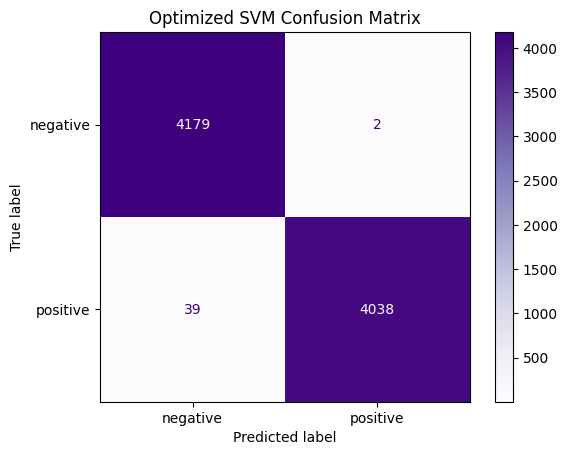

In [91]:
# Parameters for grid search
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

#setting up GridSearchCV
svm_grid_hp = GridSearchCV(SVC(random_state=42), svm_params, cv=5, verbose=1)
svm_grid_hp.fit(X_train_tfidf, y_train)

#extracting the best model
best_svm_hp = svm_grid_hp.best_estimator_
svm_predictions_hp = best_svm_hp.predict(X_test_tfidf)

#output the best parameters and classification report
print("Best SVM Parameters:", svm_grid_hp.best_params_)
print("Optimized SVM Classification Report:")
print(classification_report(y_test, svm_predictions_hp)) # classification report

#confusion matrix for the best model
plot_confusion_matrix(y_test, svm_predictions_hp, best_svm_hp.classes_, 'Optimized SVM Confusion Matrix', plt.cm.Purples)


## Deeplearning Models

In [ ]:
### Deep learning models are LSTM, GRU and RNN

In [79]:
#Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GRU, Dropout
from keras.regularizers import l2
from keras.metrics import AUC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
# Tokenize for all 3 models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_oversampled['review_text'])
X_seq = tokenizer.texts_to_sequences(df_oversampled['review_text'])
X_pad = pad_sequences(X_seq, maxlen=100)
y = pd.get_dummies(df_oversampled['sentiment']).values

#prepare training and testing data for model evaluation
X_train_pad, X_test_pad, y_train_enc, y_test_enc = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GRU, Dropout
from keras.regularizers import l2
from keras.metrics import AUC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### function to build LSTM, GRU, RNN in sections
def build_model(model_type="LSTM", additional_layer=False, regularization=False):
    """Builds a Sequential model based on the specified type and configuration."""
    model = Sequential() #model
    model.add(Embedding(5000, 128, input_length=100)) #model structure
    
    if regularization:#regularization
        model.add(Dropout(0.2))
    ### LSTM Model
    if model_type == "LSTM":
        if additional_layer:# Additional layer for hyperparameter
            model.add(LSTM(128, return_sequences=True, dropout=0.2 if regularization else 0,
                           recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
            model.add(LSTM(64, dropout=0.2 if regularization else 0,
                           recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
        else:# Regularization
            model.add(LSTM(128, dropout=0.2 if regularization else 0,
                           recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
    elif model_type == "GRU": ### GRU Model
        if additional_layer:# Additional layer for hyperparameter
            model.add(GRU(128, return_sequences=True, dropout=0.2 if regularization else 0,
                          recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
            model.add(GRU(64, dropout=0.2 if regularization else 0,
                          recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
        else: # Regularization
            model.add(GRU(128, dropout=0.2 if regularization else 0,
                          recurrent_dropout=0.2 if regularization else 0, kernel_regularizer=l2(0.01) if regularization else None))
    elif model_type == "RNN": ### RNN Model
        if additional_layer:# Additional layer for hyperparameter
            model.add(SimpleRNN(128, return_sequences=True, dropout=0.2 if regularization else 0,
                                kernel_regularizer=l2(0.01) if regularization else None))
            model.add(SimpleRNN(64, dropout=0.2 if regularization else 0,
                                kernel_regularizer=l2(0.01) if regularization else None))
        else:# Regularization
            model.add(SimpleRNN(128, dropout=0.2 if regularization else 0,
                                kernel_regularizer=l2(0.01) if regularization else None))
    
    if regularization:# Regularization
        model.add(Dropout(0.2))
    
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(0.01) if regularization else None))
    return model

### Function to compile and train all my 3 models
def compile_and_train(model, X_train, y_train, X_test, y_test, batch_size=64, epochs=5):
    """Compiles and trains the model."""
    # model compile features
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy', AUC(name='roc_auc', curve='ROC'), AUC(name='pr_auc', curve='PR')]
    )# model history features
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_test, y_test), 
        verbose=1
    )
    return history

# function for evaluation and plot
def evaluate_and_plot(model, X_test, y_test):
    """Evaluates the model and plots the confusion matrix."""
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Loss: {results[0]}, Accuracy: {results[1]}, ROC-AUC: {results[2]}, PR-AUC: {results[3]}")
    #model prediction
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Generate and print classification report
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))

    # confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model.name}')
    plt.show()

# Function to plot validations 
def plot_training_history(history, title=''):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    ### Accuracy Plots Training and Validation
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'b-', label='Validation acc')
    plt.title('Training and validation accuracy ' + title)
    plt.legend()

### Loss Plots Training and Validation
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and validation loss ' + title)
    plt.legend()
    plt.show()


### Long short-term memory - LSTM Model

Epoch 1/5
517/517 [==============================] - 100s 189ms/step - loss: 0.1829 - accuracy: 0.9334 - roc_auc: 0.9786 - pr_auc: 0.9778 - val_loss: 0.0956 - val_accuracy: 0.9701 - val_roc_auc: 0.9931 - val_pr_auc: 0.9931
Epoch 2/5
517/517 [==============================] - 106s 204ms/step - loss: 0.0618 - accuracy: 0.9813 - roc_auc: 0.9966 - pr_auc: 0.9965 - val_loss: 0.0640 - val_accuracy: 0.9807 - val_roc_auc: 0.9961 - val_pr_auc: 0.9956
Epoch 3/5
517/517 [==============================] - 102s 198ms/step - loss: 0.0441 - accuracy: 0.9856 - roc_auc: 0.9982 - pr_auc: 0.9980 - val_loss: 0.0531 - val_accuracy: 0.9840 - val_roc_auc: 0.9965 - val_pr_auc: 0.9958
Epoch 4/5
517/517 [==============================] - 116s 225ms/step - loss: 0.0244 - accuracy: 0.9926 - roc_auc: 0.9990 - pr_auc: 0.9988 - val_loss: 0.0425 - val_accuracy: 0.9887 - val_roc_auc: 0.9971 - val_pr_auc: 0.9964
Epoch 5/5
259/259 [==============================] - 7s 27ms/step - loss: 0.0513 - accuracy: 0.9874 - roc_au

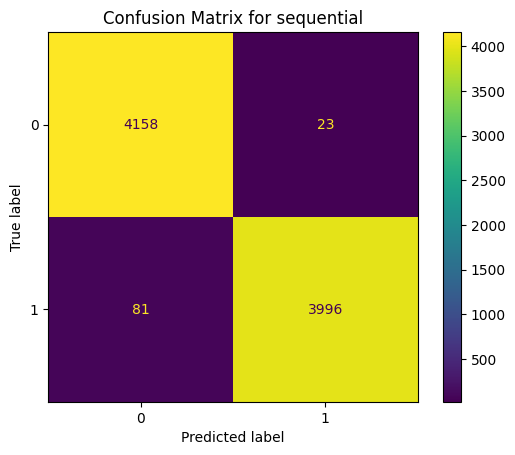

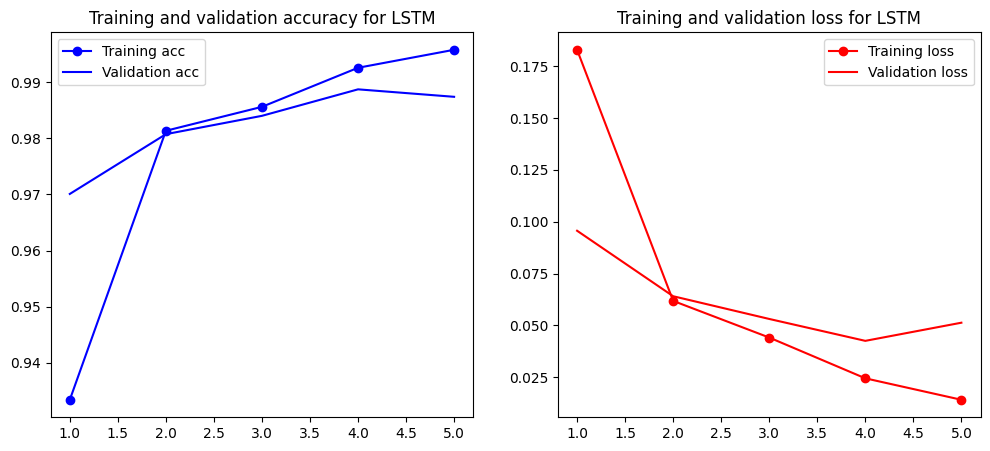

In [82]:
# Build the LSTM model 
lstm_model = build_model(model_type="LSTM", additional_layer=False, regularization=False)

#Compile and train the model
lstm_history = compile_and_train(
    lstm_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  # Using a larger batch size of 64 as a hyperparameter tunning
    epochs=5         # epochs
)

# model evaluation and confusion matrix  plot
evaluate_and_plot(lstm_model, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(lstm_history, 'for LSTM')


### HyperParameter tunning for LSTM Model

Epoch 1/5
259/259 [==============================] - 113s 424ms/step - loss: 0.2245 - accuracy: 0.9176 - roc_auc: 0.9682 - pr_auc: 0.9663 - val_loss: 0.1342 - val_accuracy: 0.9525 - val_roc_auc: 0.9869 - val_pr_auc: 0.9856
Epoch 2/5
259/259 [==============================] - 125s 481ms/step - loss: 0.0771 - accuracy: 0.9797 - roc_auc: 0.9932 - pr_auc: 0.9924 - val_loss: 0.0793 - val_accuracy: 0.9786 - val_roc_auc: 0.9924 - val_pr_auc: 0.9912
Epoch 3/5
259/259 [==============================] - 109s 420ms/step - loss: 0.0626 - accuracy: 0.9835 - roc_auc: 0.9953 - pr_auc: 0.9945 - val_loss: 0.0808 - val_accuracy: 0.9780 - val_roc_auc: 0.9922 - val_pr_auc: 0.9903
Epoch 4/5
259/259 [==============================] - 123s 477ms/step - loss: 0.0441 - accuracy: 0.9881 - roc_auc: 0.9971 - pr_auc: 0.9965 - val_loss: 0.0522 - val_accuracy: 0.9857 - val_roc_auc: 0.9960 - val_pr_auc: 0.9953
Epoch 5/5
259/259 [==============================] - 11s 43ms/step - loss: 0.0448 - accuracy: 0.9895 - roc_a

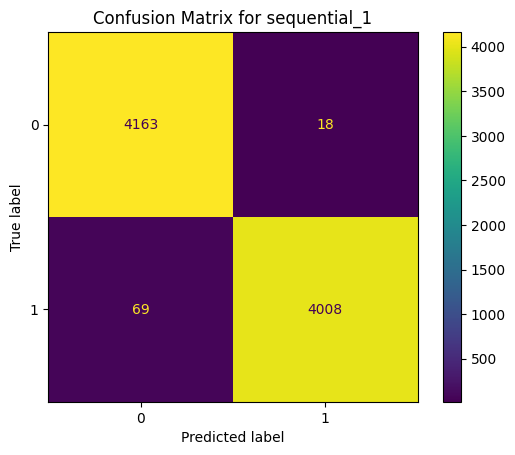

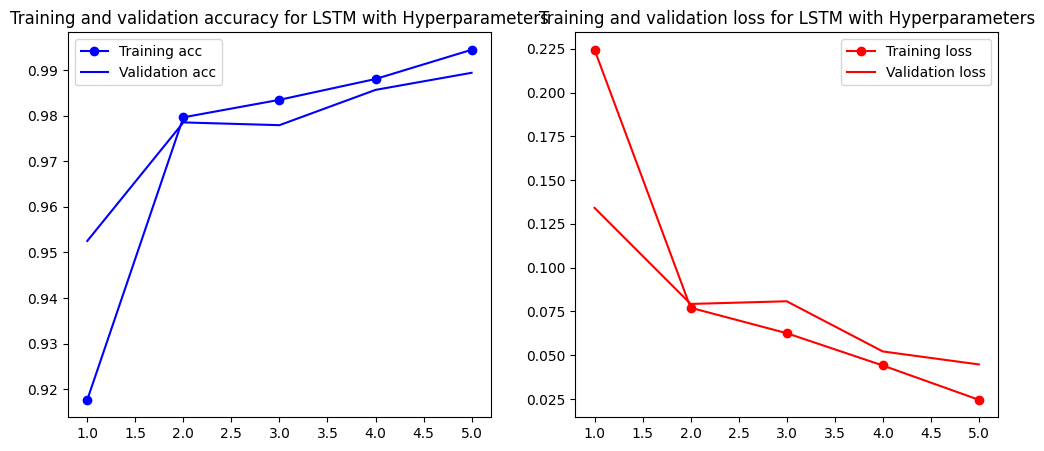

In [83]:
# Build the LSTM model with an additional layer
lstm_model_hp = build_model(model_type="LSTM", additional_layer=True, regularization=False)

# Compile and train the model
lstm_history_hp = compile_and_train(
    lstm_model_hp, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=128,  # Using a larger batch size of 128 as a hyperparameter tunning
    epochs=5         # epochs
)

# model evaluation and confusion matrix  plot
evaluate_and_plot(lstm_model_hp, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(lstm_history_hp, 'for LSTM with Hyperparameters')


### Regularization tunning for LSTM Model

Epoch 1/5
517/517 [==============================] - 137s 259ms/step - loss: 0.4912 - accuracy: 0.8858 - roc_auc: 0.9508 - pr_auc: 0.9473 - val_loss: 0.2127 - val_accuracy: 0.9575 - val_roc_auc: 0.9848 - val_pr_auc: 0.9822
Epoch 2/5
517/517 [==============================] - 133s 257ms/step - loss: 0.2015 - accuracy: 0.9596 - roc_auc: 0.9854 - pr_auc: 0.9831 - val_loss: 0.2046 - val_accuracy: 0.9644 - val_roc_auc: 0.9868 - val_pr_auc: 0.9852
Epoch 3/5
517/517 [==============================] - 134s 259ms/step - loss: 0.1980 - accuracy: 0.9612 - roc_auc: 0.9867 - pr_auc: 0.9850 - val_loss: 0.1760 - val_accuracy: 0.9688 - val_roc_auc: 0.9881 - val_pr_auc: 0.9863
Epoch 4/5
517/517 [==============================] - 139s 269ms/step - loss: 0.1389 - accuracy: 0.9760 - roc_auc: 0.9907 - pr_auc: 0.9892 - val_loss: 0.1332 - val_accuracy: 0.9746 - val_roc_auc: 0.9916 - val_pr_auc: 0.9907
Epoch 5/5
259/259 [==============================] - 5s 20ms/step - loss: 0.3063 - accuracy: 0.9192 - roc_au

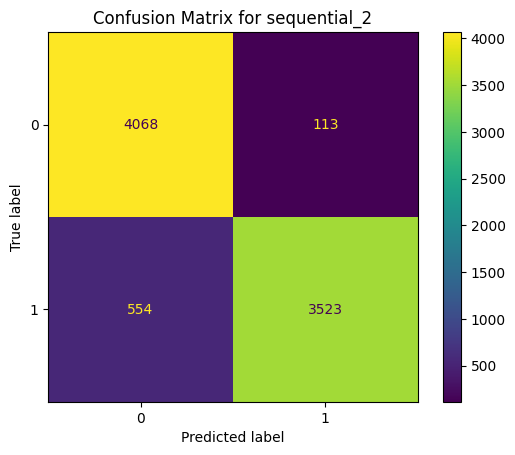

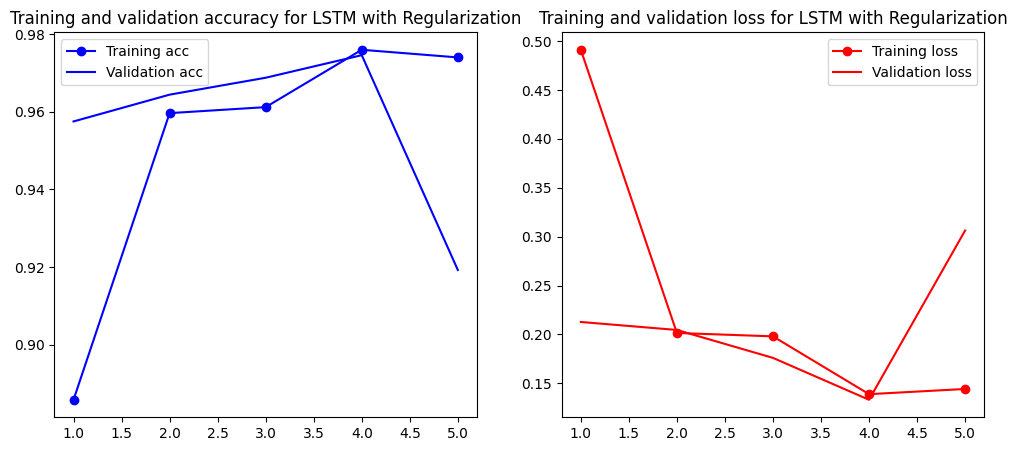

In [84]:
# Build the LSTM model with regularization
lstm_model_hp_reg = build_model(model_type="LSTM", additional_layer=False, regularization=True)

# Compile and train the model
lstm_history_hp_reg = compile_and_train(
    lstm_model_hp_reg, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  # batch size
    epochs=5         # epochs
)

# Evaluate the model and plot the confusion matrix
evaluate_and_plot(lstm_model_hp_reg, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(lstm_history_hp_reg, 'for LSTM with Regularization')


### GRU Model 

Epoch 1/5
517/517 [==============================] - 71s 133ms/step - loss: 0.1666 - accuracy: 0.9381 - roc_auc: 0.9826 - pr_auc: 0.9820 - val_loss: 0.0736 - val_accuracy: 0.9776 - val_roc_auc: 0.9958 - val_pr_auc: 0.9957
Epoch 2/5
517/517 [==============================] - 70s 134ms/step - loss: 0.0497 - accuracy: 0.9845 - roc_auc: 0.9977 - pr_auc: 0.9975 - val_loss: 0.0768 - val_accuracy: 0.9778 - val_roc_auc: 0.9950 - val_pr_auc: 0.9941
Epoch 3/5
517/517 [==============================] - 58s 113ms/step - loss: 0.0240 - accuracy: 0.9925 - roc_auc: 0.9993 - pr_auc: 0.9991 - val_loss: 0.0489 - val_accuracy: 0.9891 - val_roc_auc: 0.9957 - val_pr_auc: 0.9945
Epoch 4/5
517/517 [==============================] - 55s 106ms/step - loss: 0.0170 - accuracy: 0.9948 - roc_auc: 0.9996 - pr_auc: 0.9995 - val_loss: 0.0521 - val_accuracy: 0.9867 - val_roc_auc: 0.9961 - val_pr_auc: 0.9952
Epoch 5/5
259/259 [==============================] - 6s 22ms/step - loss: 0.0514 - accuracy: 0.9893 - roc_auc: 0

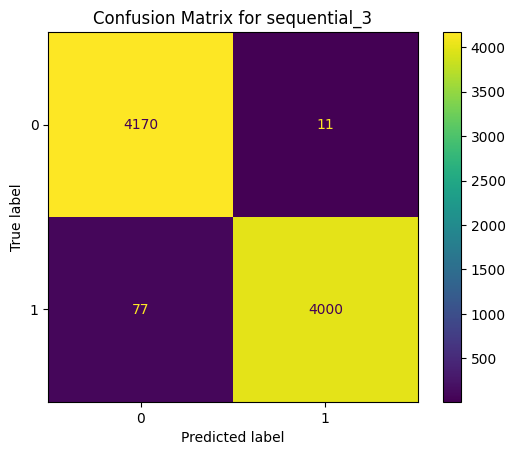

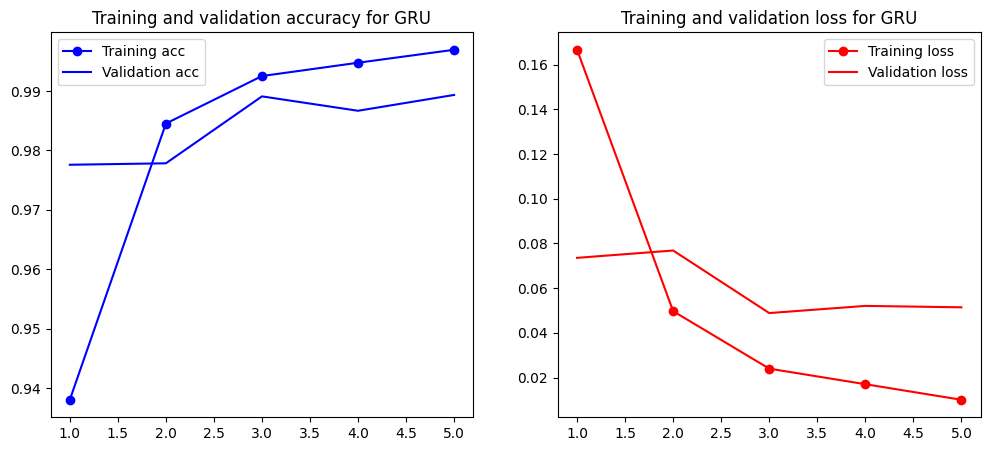

In [85]:
# Build the GRU model 
gru_model = build_model(model_type="GRU", additional_layer=False, regularization=False)

# Compile and train the model
gru_history = compile_and_train(
    gru_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  # batch size
    epochs=5         # epochs
)


# Evaluate model and plot the confusion matrix
evaluate_and_plot(gru_model, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(gru_history, 'for GRU')


### Hyperparameter tunning GRU

Epoch 1/5
259/259 [==============================] - 82s 303ms/step - loss: 0.1993 - accuracy: 0.9215 - roc_auc: 0.9752 - pr_auc: 0.9739 - val_loss: 0.1163 - val_accuracy: 0.9636 - val_roc_auc: 0.9904 - val_pr_auc: 0.9905
Epoch 2/5
259/259 [==============================] - 79s 304ms/step - loss: 0.0577 - accuracy: 0.9838 - roc_auc: 0.9964 - pr_auc: 0.9959 - val_loss: 0.0617 - val_accuracy: 0.9828 - val_roc_auc: 0.9955 - val_pr_auc: 0.9946
Epoch 3/5
259/259 [==============================] - 77s 298ms/step - loss: 0.0345 - accuracy: 0.9893 - roc_auc: 0.9983 - pr_auc: 0.9979 - val_loss: 0.0435 - val_accuracy: 0.9878 - val_roc_auc: 0.9968 - val_pr_auc: 0.9960
Epoch 4/5
259/259 [==============================] - 77s 299ms/step - loss: 0.0140 - accuracy: 0.9960 - roc_auc: 0.9995 - pr_auc: 0.9993 - val_loss: 0.0484 - val_accuracy: 0.9904 - val_roc_auc: 0.9963 - val_pr_auc: 0.9952
Epoch 5/5
259/259 [==============================] - 8s 31ms/step - loss: 0.0540 - accuracy: 0.9876 - roc_auc: 0

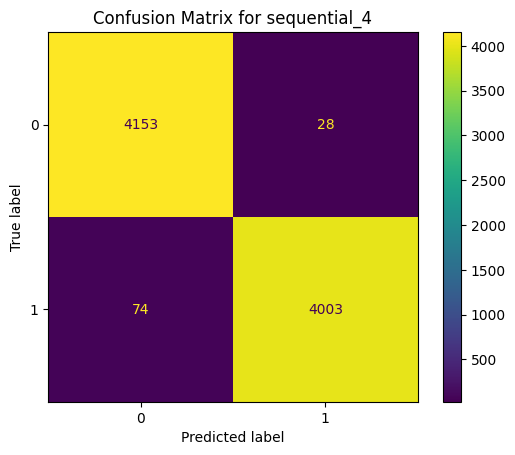

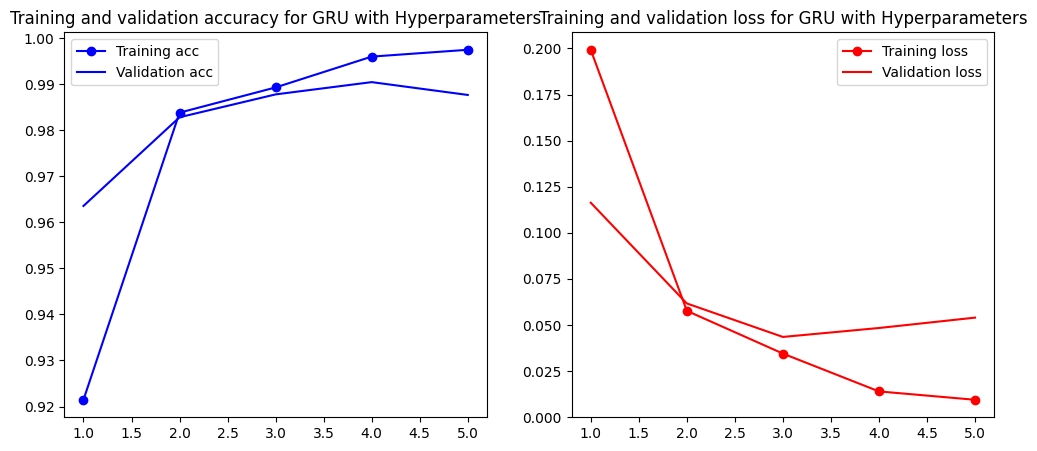

In [86]:
# Build the LSTM model with an additional layer
gru_model_hp = build_model(model_type="GRU", additional_layer=True, regularization=False)

# Compile and train the model
gru_history_hp = compile_and_train(
    gru_model_hp, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=128,  # Using a larger batch size 128 for hyperparameter 
    epochs=5         # epochs
)

# Evaluate model and plot the confusion matrix
evaluate_and_plot(gru_model_hp, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(gru_history_hp, 'for GRU with Hyperparameters')


### Regularization tunning for GRU Model

Epoch 1/5
517/517 [==============================] - 93s 175ms/step - loss: 0.4334 - accuracy: 0.8991 - roc_auc: 0.9609 - pr_auc: 0.9595 - val_loss: 0.2243 - val_accuracy: 0.9499 - val_roc_auc: 0.9839 - val_pr_auc: 0.9834
Epoch 2/5
517/517 [==============================] - 91s 176ms/step - loss: 0.1783 - accuracy: 0.9604 - roc_auc: 0.9875 - pr_auc: 0.9868 - val_loss: 0.1657 - val_accuracy: 0.9632 - val_roc_auc: 0.9861 - val_pr_auc: 0.9843
Epoch 3/5
517/517 [==============================] - 97s 188ms/step - loss: 0.1568 - accuracy: 0.9646 - roc_auc: 0.9893 - pr_auc: 0.9882 - val_loss: 0.1491 - val_accuracy: 0.9654 - val_roc_auc: 0.9903 - val_pr_auc: 0.9903
Epoch 4/5
517/517 [==============================] - 94s 182ms/step - loss: 0.1415 - accuracy: 0.9699 - roc_auc: 0.9923 - pr_auc: 0.9918 - val_loss: 0.1327 - val_accuracy: 0.9702 - val_roc_auc: 0.9935 - val_pr_auc: 0.9935
Epoch 5/5
259/259 [==============================] - 4s 15ms/step - loss: 0.1648 - accuracy: 0.9634 - roc_auc: 0

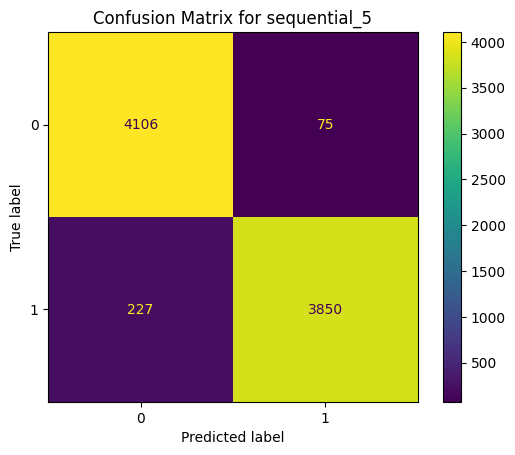

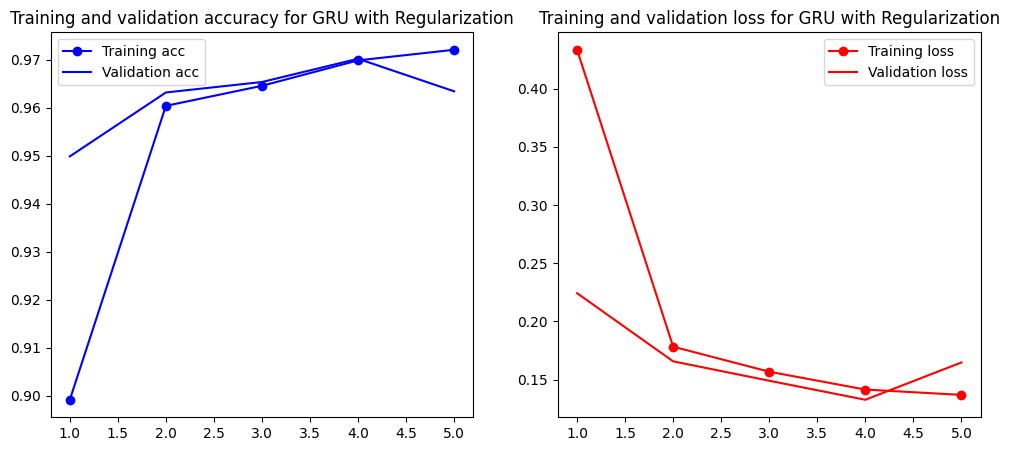

In [87]:
# Build the GRU model with regularization
gru_model_hp_reg = build_model(model_type="GRU", additional_layer=False, regularization=True)

# Compile and train the model
gru_history_hp_reg = compile_and_train(
    gru_model_hp_reg, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  #  batch size
    epochs=5         # epochs 
)

# Evaluate model and plot the confusion matrix
evaluate_and_plot(gru_model_hp_reg, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(gru_history_hp_reg, 'for GRU with Regularization')


### RNN model

Epoch 1/5
517/517 [==============================] - 28s 51ms/step - loss: 0.1754 - accuracy: 0.9312 - roc_auc: 0.9815 - pr_auc: 0.9815 - val_loss: 0.0618 - val_accuracy: 0.9795 - val_roc_auc: 0.9970 - val_pr_auc: 0.9969
Epoch 2/5
517/517 [==============================] - 26s 51ms/step - loss: 0.0280 - accuracy: 0.9921 - roc_auc: 0.9991 - pr_auc: 0.9989 - val_loss: 0.0321 - val_accuracy: 0.9914 - val_roc_auc: 0.9980 - val_pr_auc: 0.9976
Epoch 3/5
517/517 [==============================] - 27s 53ms/step - loss: 0.1357 - accuracy: 0.9500 - roc_auc: 0.9880 - pr_auc: 0.9874 - val_loss: 0.1133 - val_accuracy: 0.9626 - val_roc_auc: 0.9910 - val_pr_auc: 0.9903
Epoch 4/5
517/517 [==============================] - 27s 52ms/step - loss: 0.0573 - accuracy: 0.9823 - roc_auc: 0.9971 - pr_auc: 0.9968 - val_loss: 0.0609 - val_accuracy: 0.9822 - val_roc_auc: 0.9961 - val_pr_auc: 0.9956
Epoch 5/5
259/259 [==============================] - 2s 8ms/step - loss: 0.0866 - accuracy: 0.9730 - roc_auc: 0.9932

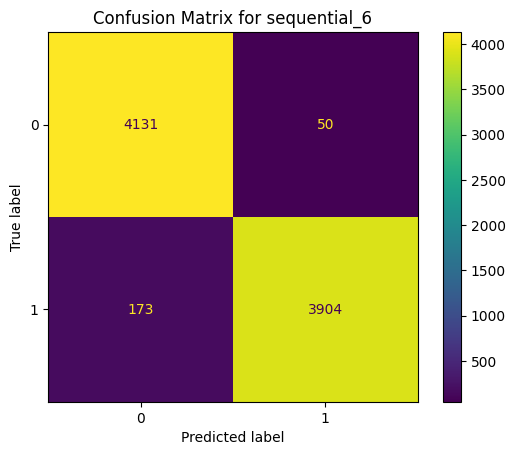

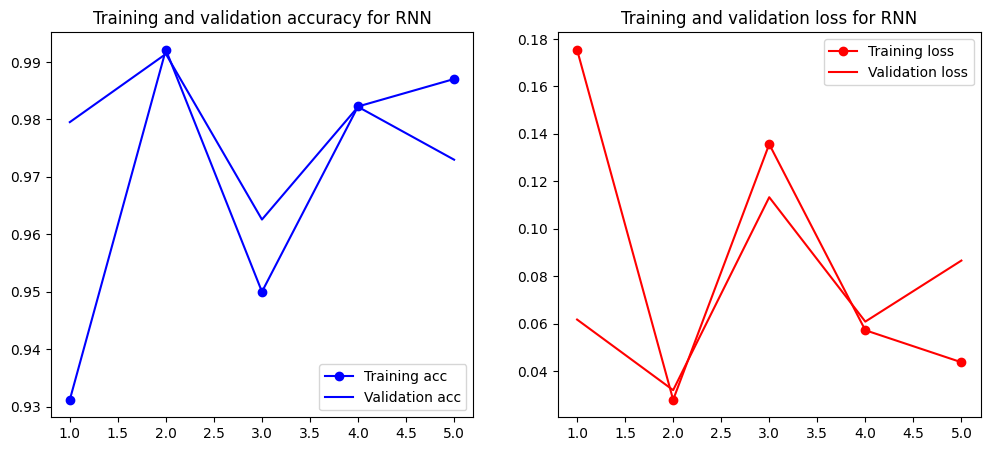

In [88]:
# Build the RNN model 
rnn_model = build_model(model_type="RNN", additional_layer=False, regularization=False)

# Compile and train the model
rnn_history = compile_and_train(
    rnn_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  #  batch size 
    epochs=5         #  epochs 
)

# Evaluate model and plot the confusion matrix
evaluate_and_plot(rnn_model, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(rnn_history, 'for RNN')


### RNN Hyperparameters model

Epoch 1/5
259/259 [==============================] - 28s 100ms/step - loss: 0.2354 - accuracy: 0.8872 - roc_auc: 0.9655 - pr_auc: 0.9667 - val_loss: 0.0604 - val_accuracy: 0.9801 - val_roc_auc: 0.9969 - val_pr_auc: 0.9968
Epoch 2/5
259/259 [==============================] - 25s 98ms/step - loss: 0.0227 - accuracy: 0.9939 - roc_auc: 0.9992 - pr_auc: 0.9990 - val_loss: 0.0294 - val_accuracy: 0.9931 - val_roc_auc: 0.9983 - val_pr_auc: 0.9978
Epoch 3/5
259/259 [==============================] - 26s 102ms/step - loss: 0.0068 - accuracy: 0.9985 - roc_auc: 0.9999 - pr_auc: 0.9999 - val_loss: 0.0269 - val_accuracy: 0.9929 - val_roc_auc: 0.9983 - val_pr_auc: 0.9979
Epoch 4/5
259/259 [==============================] - 26s 101ms/step - loss: 0.0032 - accuracy: 0.9991 - roc_auc: 1.0000 - pr_auc: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.9883 - val_roc_auc: 0.9968 - val_pr_auc: 0.9959
Epoch 5/5
259/259 [==============================] - 3s 12ms/step - loss: 0.0218 - accuracy: 0.9949 - roc_auc: 0.

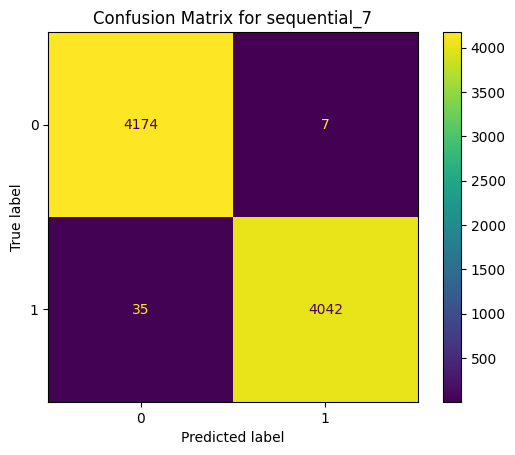

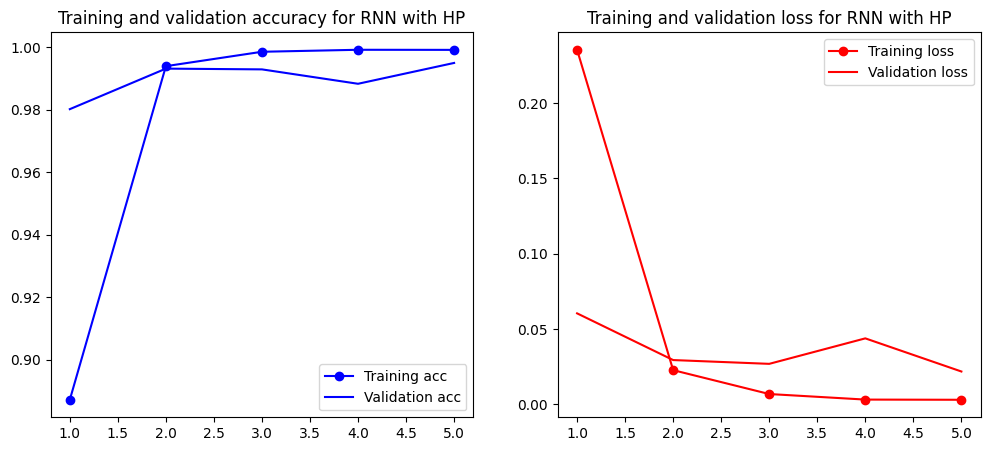

In [89]:
# Build the RNN model with an additional layer
rnn_model_hp = build_model(model_type="RNN", additional_layer=True, regularization=False)

# Compile and train the model
rnn_history_hp = compile_and_train(
    rnn_model_hp, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=128,  # Using a larger batch size as a hyperparameter tunning
    epochs=5         # epochs
)

# Evaluate model and plot the confusion matrix
evaluate_and_plot(rnn_model_hp, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(rnn_history_hp, 'for RNN with HP')


### RNN Regularizer model

Epoch 1/5
517/517 [==============================] - 31s 57ms/step - loss: 0.5828 - accuracy: 0.8409 - roc_auc: 0.9197 - pr_auc: 0.9185 - val_loss: 0.3463 - val_accuracy: 0.9070 - val_roc_auc: 0.9641 - val_pr_auc: 0.9643
Epoch 2/5
517/517 [==============================] - 26s 51ms/step - loss: 0.2448 - accuracy: 0.9383 - roc_auc: 0.9800 - pr_auc: 0.9792 - val_loss: 0.1804 - val_accuracy: 0.9606 - val_roc_auc: 0.9894 - val_pr_auc: 0.9892
Epoch 3/5
517/517 [==============================] - 29s 57ms/step - loss: 0.1585 - accuracy: 0.9655 - roc_auc: 0.9915 - pr_auc: 0.9910 - val_loss: 0.1901 - val_accuracy: 0.9530 - val_roc_auc: 0.9881 - val_pr_auc: 0.9875
Epoch 4/5
517/517 [==============================] - 36s 70ms/step - loss: 0.1350 - accuracy: 0.9724 - roc_auc: 0.9933 - pr_auc: 0.9927 - val_loss: 0.1254 - val_accuracy: 0.9748 - val_roc_auc: 0.9932 - val_pr_auc: 0.9927
Epoch 5/5
259/259 [==============================] - 2s 9ms/step - loss: 0.1379 - accuracy: 0.9709 - roc_auc: 0.9915

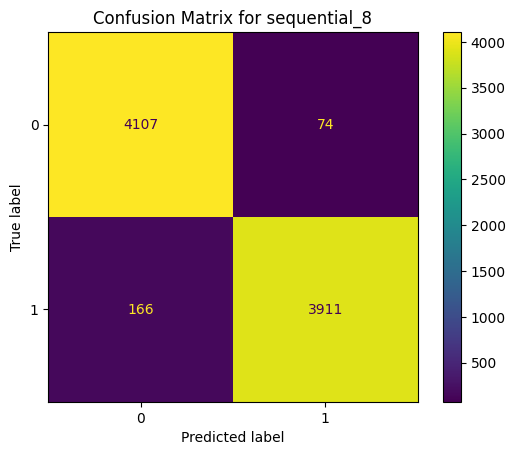

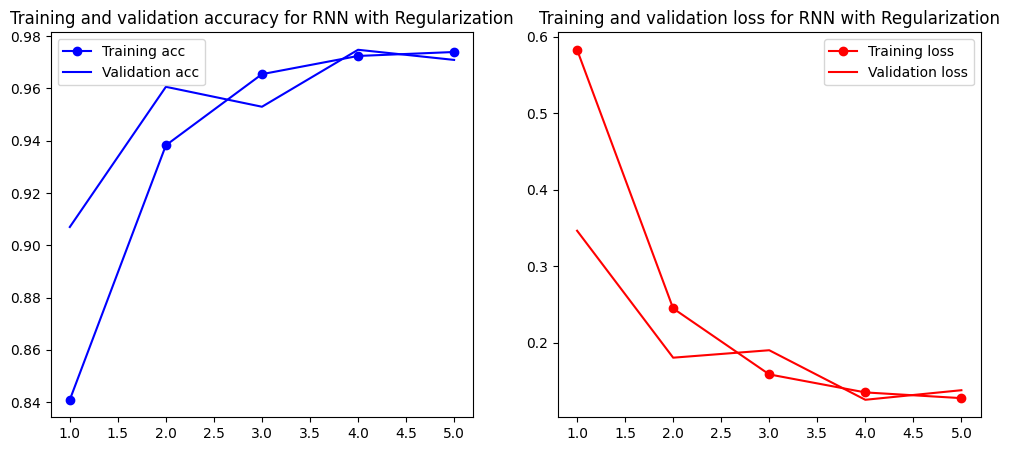

In [90]:
# Build the RNN model with regularization
rnn_model_hp_reg = build_model(model_type="RNN", additional_layer=False, regularization=True)

# Compile and train the model
rnn_history_hp_reg = compile_and_train(
    rnn_model_hp_reg, X_train_pad, y_train_enc, X_test_pad, y_test_enc, 
    batch_size=64,  #  batch size 
    epochs=5         # epochs
)

# Evaluate model and plot the confusion matrix
evaluate_and_plot(rnn_model_hp_reg, X_test_pad, y_test_enc)

# Plot training history
plot_training_history(rnn_history_hp_reg, 'for RNN with Regularization')


### Model Evaluation

Each model was evaluated using accuracy and F1 scores. Among traditional machine learning models, the Support Vector Machines (SVM) achieved the highest performance with an accuracy of 1.00 and an F1 score of 1.00. In the deep learning category, the Long Short-term Memory (LSTM) model outperformed others with an accuracy of 0.989 and an F1 score of 0.99. Fine-tuning techniques such as hyperparameter tuning and regularization were used to observe model performance. The results were visualized using confusion matrices to show classification performance and training history plots to illustrate the learning process of the deep learning models. 